<font color='seagreen'>


# Week 3 -- Radiation Basics and Energy Balance
*Please finish and submit this project before the start of class on 20 September 2017.*

This week, we will play with the Planck function and investigate how energy transport via radiation sets the basic temperature scale for planets' atmospheres.

In [55]:
import matplotlib.pyplot as plt 
import numpy as np
from astropy import units, constants
from astropy.io import ascii
import seaborn as sns

sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline

<font color='seagreen'>
### Q1: 

The Planck function expresses the *intensity* from a thermal emitting source. In terms of wavelength (in a form that can be integrated against $d\lambda$), it can be written as 

$$B_{\lambda}(\lambda, T) = \frac{{2hc}^2}{\lambda^5}\frac{1}{e^{hc/\lambda k_BT} - 1}$$

and has units that are equivalent to $J~{s}^{-1}~{m}^{-2}~{sr}^{-1}~{\mu m}^{-1}$. (Note that the  ${\mu m}^{-1}$ in refers to the width of the wavelength range $d\lambda$ -- something you'll see $m$, $nm$, $angstrom$, or other units instead.)

+ Write a function that accepts an array of wavelengths and temperature, and returns the thermal emission *flux* $F_\lambda(\lambda, T)$ at those wavelengths and that temperature. Recall that because thermal emission is isotropic, the *flux* of radiation away from a surface, integrated over solid angle, is given by $F_{\lambda}(\lambda, T) = \pi B_\lambda(\lambda, T)$. 

In [56]:
def planck_flux(wavelength, temperature):
    '''
    This function calculates the thermal emission spectrum of a surface.
    
        Inputs:
            wavelength = numpy array of wavelengths (in nm)
            temperature = a single number, the temperature (in K)
    
        Outputs:
            Returns an array of thermal emission fluxes,
            in units of J/(s*m^2*micron). This is a flux, which has 
            already been integrated over solid angle.
    '''
    frac_factor = 2.0*constants.h*(constants.c**2.0)/(wavelength**5.0)
    exp_power = (constants.h*constants.c/(wavelength*constants.k_B*temperature)).to(units.dimensionless_unscaled)
    denom = np.exp(exp_power) - 1.0
    flux = np.pi*(frac_factor/(denom)).to(units.J/(units.s*(units.m**2.0)*units.micron))
    # CALCULATE AN ARRAY FOR THE FLUX HERE
    return flux

<font color='seagreen'>
+ Make a plot of $\lambda$ vs. $F_\lambda(\lambda, T=300~K)$, covering $1-100~\mu m$. Wien's Law states that the peak of this spectrum will be at $\lambda_{\rm max} = b/T$, with $b = 2900~\mu m~K$. To make sure you have your horizontal axis lined up appropriately, plot a vertical line at this predicted peak location.

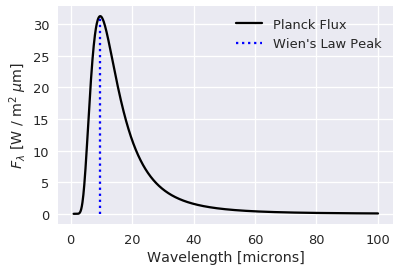

In [74]:
wave_array = np.linspace(1, 100.0, 1000)*units.micron
temp = 300.0*units.K
flux = planck_flux(wave_array, temp)
wien_peak = (2900.0*units.K*units.micron)/temp
wien_plot_x = np.ones((100))*wien_peak
wien_plot_y = np.linspace(0.0, np.max(flux), 100)
plt.plot(wave_array, flux, '-k', label='Planck Flux')
plt.plot(wien_plot_x, wien_plot_y, ':b',label='Wien\'s Law Peak')
plt.xlabel('Wavelength [microns]')
plt.ylabel(r'$F_\lambda$ [W / m$^{2}$ $\mu$m]')
plt.legend()

<font color='seagreen'>
+ The Stefan-Boltzmann Law states that the bolometric flux from a surface is
$$F_{\rm bol}(T) = \int^{\infty}_{0}F_{\lambda}(\lambda, T)d\lambda = \sigma_{\rm SB}T^4$$
in units of $W/m^2$. To make sure you have the units and overall scale of your Planck function correct, let's make sure we can recover this result. Numerically integrate your Planck function over wavelength, and compare it to the value from this analytic expression. (There are a couple of ways to do this numerical integral; `np.trapz` can integrate along a defined grid of $y$ and $x$, or `scipy.integrate` has tools for directly integrating a function between limits.)

In [79]:
wave_array_2 = np.linspace(0.0001, 100000.0, 100000)*units.micron
flux_2 = planck_flux(wave_array_2, temp)
bol_flux = np.trapz(flux_2, wave_array_2)
print_str_1 = 'Integrated flux from Planck blackbody curve is: ' + str(bol_flux.to(units.W/(units.m**2.0)))
print(print_str_1)
sb_flux = (temp**4.0)*(constants.sigma_sb)
print_str_2 = 'Predicted flux from Stefan-Boltzmann law is: ' + str(sb_flux)
print(print_str_2)
percent_diff = 100.0*((sb_flux - bol_flux )/ bol_flux).to(units.dimensionless_unscaled)
print_str_3 = 'Percentage difference is: ' + str(percent_diff)+ '%'
print(print_str_3)

Integrated flux from Planck blackbody curve is: 459.2995723664336 W / m2
Predicted flux from Stefan-Boltzmann law is: 459.29972699999996 W / m2
Percentage difference is: 3.366725676591749e-05%


/home/girish/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


<font color='seagreen'>
### Q2: What color is a star?

When we look at a source whose spectrum is $F_\lambda(\lambda)$, our eyes are basically calculating three integrals of that spectrum over wavelength. We perceive different colors as different ratios among these three integrals. Let's write some code to approximate these integrals, so we can display spectra as colors on our computer screens. Flux integrals like these pop up [all the time](https://ui.adsabs.harvard.edu/#abs/2005ARA&A..43..293B/abstract) in astronomy, where we talk about flux through broadband photometric filters.

First, we need to know the effective response of the cones in our eyes to different wavelengths of light. We can approximate these using three "color matching functions" $\bar{x}(\lambda)$, $\bar{y}(\lambda)$, and $\bar{z}(\lambda)$.  The file `ciexyz31.csv` contains a table of these three functions. Load in these color matching functions, and use them to calculate the following three quantities:

$$X = \int F_{\lambda}(\lambda)~\bar{x}(\lambda)~d\lambda $$
$$Y = \int F_{\lambda}(\lambda)~\bar{y}(\lambda)~d\lambda $$
$$Z = \int F_{\lambda}(\lambda)~\bar{z}(\lambda)~d\lambda $$

These are integrals of the intrsinsic spectrum, weighted by the sensitivity of each "filter" to light at each wavelength. You can think of $X$, $Y$, and $Z$ roughly as the brightness of three colored lamps ("pseudo-red", "pseudo-green", "pseudo-blue") which all mix together to form the final color. However, these pseudo-colors aren't exactly the RGB ("red", "green", "blue") colors that our screens display. To get to actual RGB values, these need to be stretched and squeezed a little bit through a linear matrix transformation. The function `xyz2rgb` below handles this conversion for you. 

The final RGB color for a given spectrum should be an array of three numbers, all between 0 and 1. For example, an RGB array of `[0.0, 0.0, 1.0]` means "no brightness in R and G, and full brightness in B", so the color would appear blue. 

+ Make a plot showing $\lambda$ vs. $F_{\lambda}(\lambda, T)$ for temperatures ranging from $3000~K$ to $10000~K$ in $1000~K$ increments. In your plot, set the color of each curve to the RGB color you calculate for that spectrum. 

+ Discuss the overall features you see. Why are there no bright green stars?

We're going to use this code a few more times in this class!


In [59]:
import pandas as pd
df = pd.read_csv('ciexyz31.csv', skiprows=4)
wave_df = np.array(df['wavelength'])*units.nm
x_func = np.array(df[' X'])
y_func = np.array(df[' Y'])
z_func = np.array(df[' Z'])

In [60]:
def xyz2rgb(X, Y, Z):
    '''
    This function converts CIE XYZ values into CIE RGB values.
    '''

    # normalize these, so they're all between 0 and 1
    x = X/(X+Y+Z)
    y = Y/(X+Y+Z)
    z = Z/(X+Y+Z)

    # make a single column matrix containing the x,y,z values
    xyz = np.matrix([x,y,z]).T
    
    # rgb = conversion * xyz (with matrix math)
    conversion = np.matrix([[0.41847, -0.15866, -0.082835],
                            [-0.091169, 0.25243, 0.015708],
                            [0.00092090, -0.0025498, 0.17860]])
    
    # calculate the rgb single-column matrix
    color_matrix = conversion*xyz

    # 
    color = np.array(color_matrix.T)[0]
    color = color/np.max(color)
    
    return color

/home/girish/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


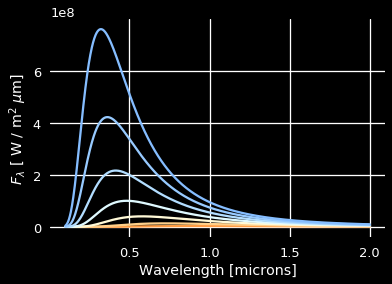

In [61]:
def get_component_flux(component, temp):
    flux = planck_flux(wave_df, temp)
    return np.trapz(flux*component, wave_df)

def get_xyz(temp):
    x_flux = get_component_flux(x_func, temp)
    y_flux = get_component_flux(y_func, temp)
    z_flux = get_component_flux(z_func, temp)
    return x_flux, y_flux, z_flux

def temp_to_rgb(temp):
    x, y, z = get_xyz(temp)
    return xyz2rgb(x, y, z)

def get_plot_f(wavelength, temp):
    rgb = temp_to_rgb(temp)
    flux = planck_flux(wavelength, temp)
    return flux, rgb

temp_array = np.arange(3000.0, 10000.0, 1000)
wave_array = np.linspace(0.1, 2.0, 1000.0)

plt.style.use('dark_background')
plt.figure()
for temp in temp_array:
    flux, rgb = get_plot_f(wave_array*units.micron, temp*units.K)
    plt.plot(wave_array, flux, color=rgb)

plt.xlabel('Wavelength [microns]')
plt.ylabel(r'$F_\lambda$ [ W / m$^{2}$ $\mu$m]')

$\textrm{Looking at the response functions of the eye's color receptors (Wikipedia article on color vision),}$
$\textrm{there is a trough at around 480 nm, roughly where "green" is.}$
$\textrm{Even though a star may peak there, given our relative weighting of red and blue, we would not see it as green.}$
$\textrm{Note how in that region, a star peaking there appears almost white: a roughly even split between red, green, and blue.}$ 

<font color='seagreen'>
### Q3: Energy Balance

The average bolometric flux the Earth receives from the Sun (the "solar constant") is roughly $1360~W/m^2$. The Bond albedo of the Earth, averaged over the incoming solar spectrum, is about $A_B = 0.3$. 

+ What is the total power $[W]$ absorbed by the Earth?
+ What is the total power $[W]$ Earth reflects away to space?
+ What is the equilibrium temperature $T_{eq, \oplus}$ of the Earth? Earth's atmosphere does a  good job of distributing incoming heat evenly across the planet, so you can assume the planet radiates with the same $T_{eq}$ at all latitudes and longitudes.
+ Make a plot of planetary equilibrium temperatures vs. planetary radius, including both the Solar System planets (`solarsystem.txt`) and most of the current confirmed extrasolar planets (`exoplanets.txt`). You can assume (wildly! boldly! inappropriately!) that all planets are in circular orbits and they efficiently redistribute their absorbed energy globally, and that the exoplanets have Bond albedos of $A_B=0.25$.

The power absorbed by the Earth is: 1.2001113691097485e+17 W

The power reflected by the Earth is: 5.341536151528939e+16 W

The equilibrium temperature of Earth is: 253.80107705338213 K


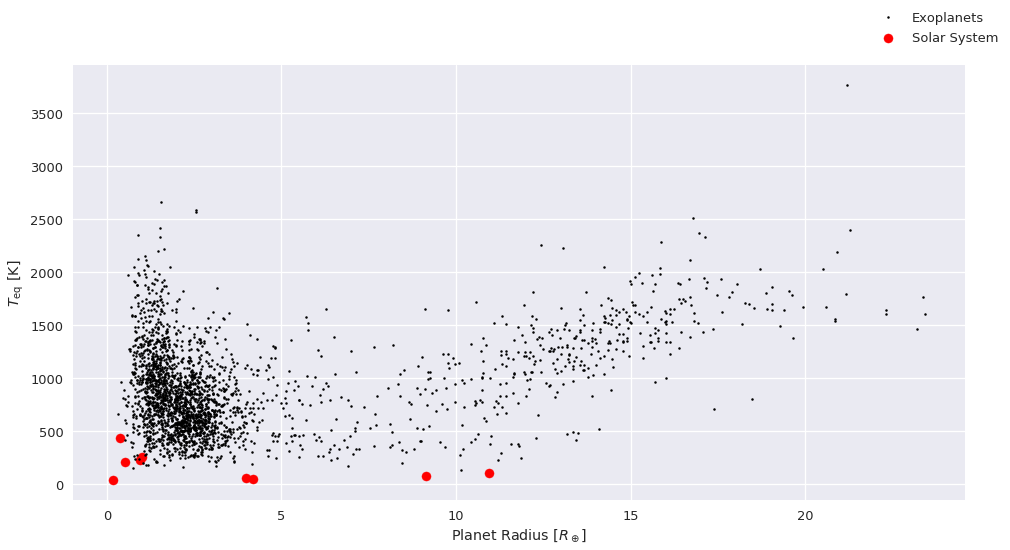

In [62]:
sa_Earth = 4.0*np.pi*((0.9989*constants.R_earth)**2.0)
solar_constant = 1360.0*(units.W/(units.m**2.0))
albedo = 0.308
power_absorbed = (1.0 - albedo)*(sa_Earth/4.0)*(solar_constant)
print_str_1 = 'The power absorbed by the Earth is: ' + str(power_absorbed.to(units.W)) + '\n'
print(print_str_1)
power_reflected = albedo*(sa_Earth/4.0)*(solar_constant)
print_str_2 = 'The power reflected by the Earth is: ' + str(power_reflected.to(units.W)) + '\n'
eq_temp_earth = (power_absorbed/(constants.sigma_sb*(sa_Earth)))**(0.25)
print(print_str_2)
print_str_3 = 'The equilibrium temperature of Earth is: ' + str(eq_temp_earth)
print(print_str_3)

solar_system = ascii.read('solarsystem.txt')
exoplanets = ascii.read('exoplanets.txt')

solar_teff = 5780.0*units.K
solar_planet_rad = solar_system['planet_radius']*units.R_earth
solar_planet_axis = solar_system['planet_a']*units.AU
solar_planet_albedo = solar_system['planet_albedo']

exo_stell_rad = exoplanets['star_radius']*units.R_sun
exo_teff = exoplanets['star_teff']*units.K
exo_axis = exoplanets['planet_a']*units.AU
exo_planet_rad = exoplanets['planet_radius']*units.R_earth

def temp_planet(axis, planet_radius, star_radius, star_teff, albedo=0.25):
    sa_planet = 4.0*np.pi*(planet_radius**2.0)
    distance = axis.to(units.AU)
    star_lum = (constants.sigma_sb*(4.0*np.pi*(star_radius**2.0)*(star_teff**4.0))).to(units.W)
    power_absorbed = (star_lum/(4.0*np.pi*(distance**2.0)))*(sa_planet/4.0)*(1.0 - albedo)
    eq_temp = (power_absorbed/(constants.sigma_sb*sa_planet))**(0.25)
    return eq_temp.to(units.K)

eq_temp_solar = temp_planet(solar_planet_axis, solar_planet_rad, constants.R_sun, solar_teff, solar_planet_albedo)
eq_temp_exo = temp_planet(exo_axis, exo_planet_rad, exo_stell_rad, exo_teff)
all_temp = np.append(eq_temp_solar.value, eq_temp_exo.value)
all_rad = np.append(solar_planet_rad.value, exo_planet_rad.value)
sns.set_style('darkgrid')
sns.set_context('talk')
plt.figure(figsize=(16, 8))
plt.scatter(solar_planet_rad.value, eq_temp_solar.value, marker='o', color='r', label='Solar System')
plt.plot(exo_planet_rad.value, eq_temp_exo.value, '.k', markersize=5, label='Exoplanets')
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.15))
plt.xlabel(r'Planet Radius [$R_\oplus$]')
plt.ylabel(r'$T_{\mathrm{eq}}$ [K]')

<font color='seagreen'>

### Q4: Cartoon Spectra of Planets

In Q3, we balanced the bolometric flux into and out of a planet. In this question, we will investigate the the wavelength-dependence of that light. Let's imagine we have fleets of satellites with spectrometers than can measure spectral flux [$W/m^2/\mu m$ or some related units] over a very broad wavelength range. We place these satellites in close orbits around each of the Solar System planets, and use them to measure the average spectral flux eminating from 
them. 

+ Using the data in `solarsystem.txt`, make a plot of the pan-chromatic spectrum of each of the Solar System planets. These spectra should span $0.1-100\mu m$ in wavelength, and should reflect the average (over all angles) spectral flux we would measure for these planets. Be sure to include both reflected and emitted components of the spectrum. Treat the Sun and planets as simple thermal Planck emitters. When calculating the reflected light, make the (inappropriate) assumption that the albedo is constant across wavelength.
+ For each planet, indicate the approximate wavelength where the spectrum switches between being dominated by reflected light to being dominated by thermal emission from the planet itself.
+ Pick one exoplanet from the `exoplanets.txt` table, and make a cartoon spectrum for it. (Feel free to make up whatever albedo you want for the exoplanet.)

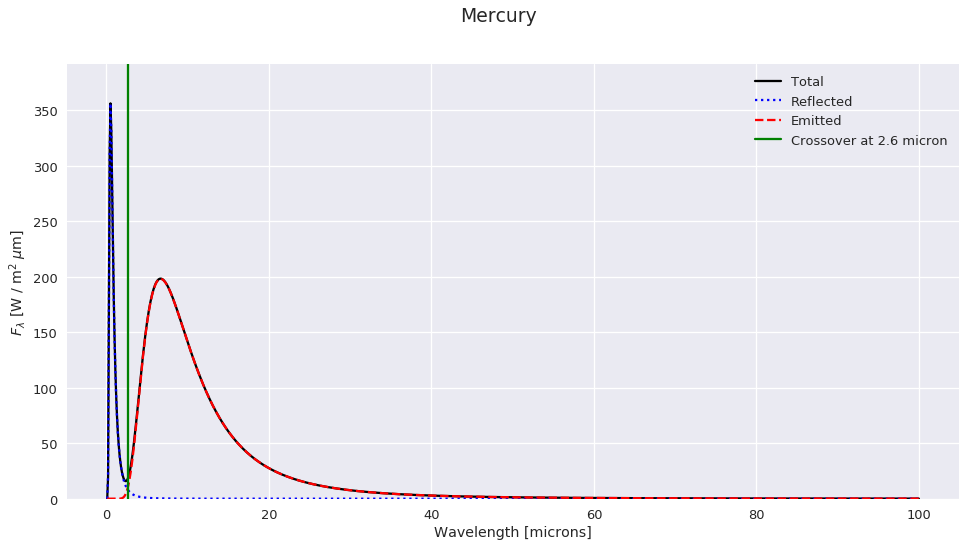

In [63]:
def get_spectrum(axis, planet_radius, star_radius, star_teff, albedo, wave_array):
    eq_temp = temp_planet(axis, planet_radius, star_radius, star_teff, albedo)
    emitted_spectrum = (planck_flux(wave_array, eq_temp)).to(units.W/(units.micron*(units.m**2.0)))
    reflected_spectrum = (planck_flux(wave_array, star_teff)*((star_radius/axis)**2.0)*albedo/4.0).to(units.W/(units.micron*(units.m**2.0)))
    total_spectrum = emitted_spectrum + reflected_spectrum
    crossover = wave_array[np.where(emitted_spectrum >= reflected_spectrum)[0]][0]
    return crossover, total_spectrum, emitted_spectrum, reflected_spectrum

def plot_spectrum(crossover, total, emit, reflect, title, wave_array):
    plt.figure(figsize=(16,8))
    plt.plot(wave_array, total, '-k', label='Total')
    plt.plot(wave_array, reflect, ':b', label='Reflected')
    plt.plot(wave_array, emit, '--r', label='Emitted')
    plt.suptitle(title)
    plt.ylim(0.0, 1.1*np.max(total).value)
    crossover_str = 'Crossover at '+ str(crossover)
    plt.plot([crossover.value]*100, np.linspace(0.0, 1.1*np.max(total).value, 100), '-g', label=crossover_str)
    plt.legend(loc='upper right')
    plt.xlabel('Wavelength [microns]')
    plt.ylabel(r'$F_\lambda$ [W / m$^{2}$ $\mu$m]')

wave_array = np.linspace(0.1, 100.0, 1000)*units.micron
titles = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', '55 Cancri e']
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[0], solar_planet_rad[0],
                                               constants.R_sun, solar_teff, solar_planet_albedo[0], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[0], wave_array)
    
    

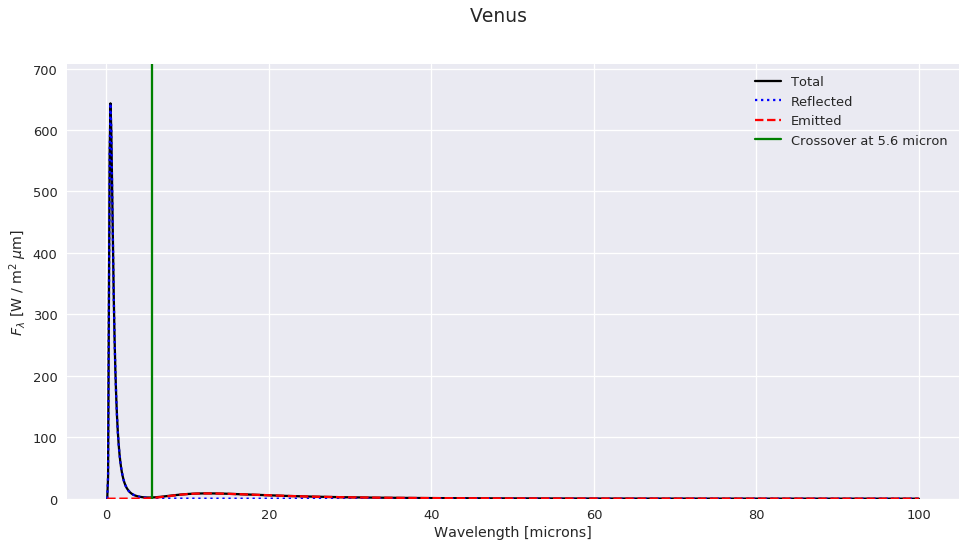

In [64]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[1], solar_planet_rad[1],
                                               constants.R_sun, solar_teff, solar_planet_albedo[1], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[1], wave_array)

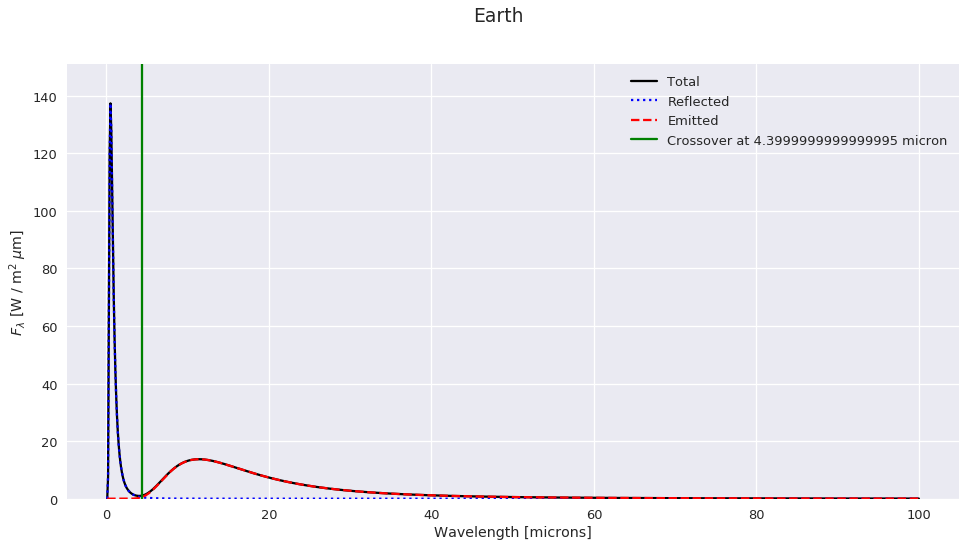

In [65]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[2], solar_planet_rad[2],
                                               constants.R_sun, solar_teff, solar_planet_albedo[2], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[2], wave_array)

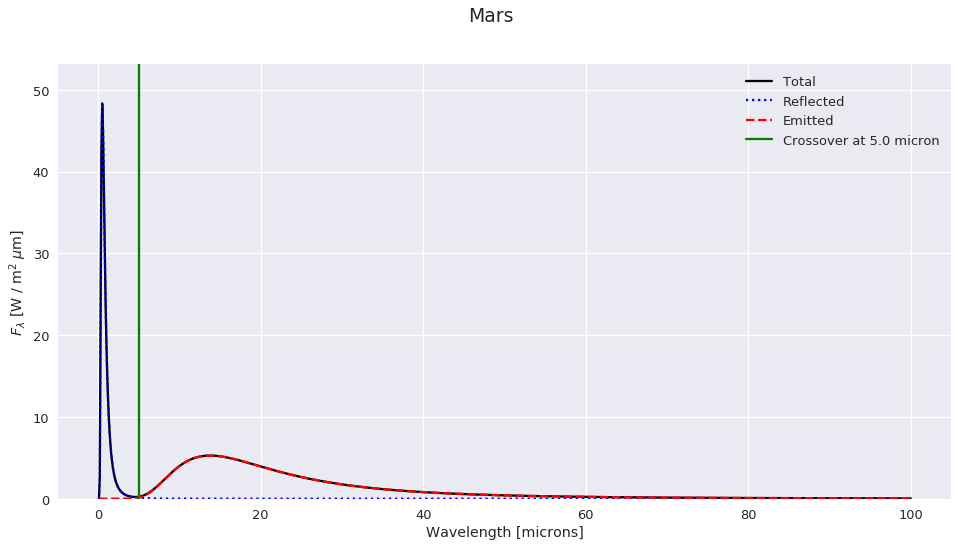

In [66]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[3], solar_planet_rad[3],
                                               constants.R_sun, solar_teff, solar_planet_albedo[3], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[3], wave_array)

/home/girish/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


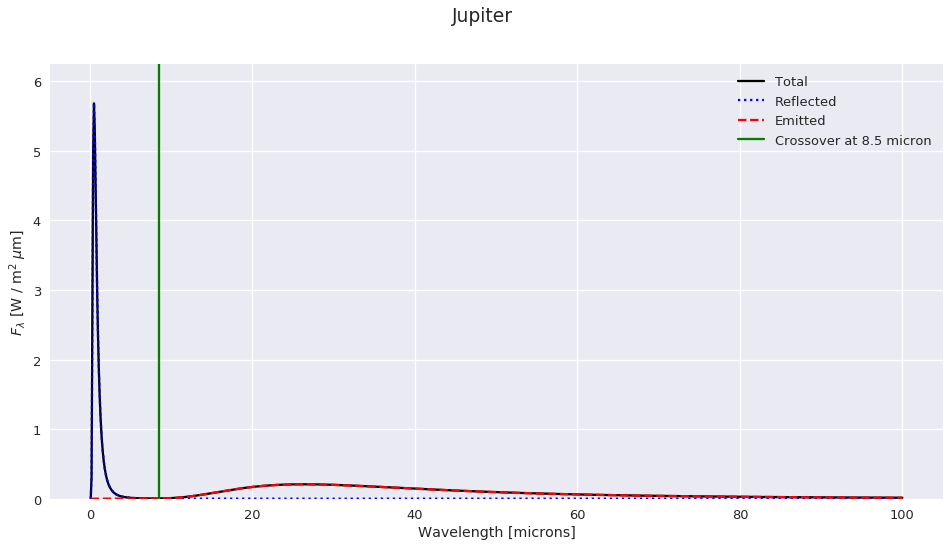

In [67]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[4], solar_planet_rad[4],
                                               constants.R_sun, solar_teff, solar_planet_albedo[4], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[4], wave_array)

/home/girish/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


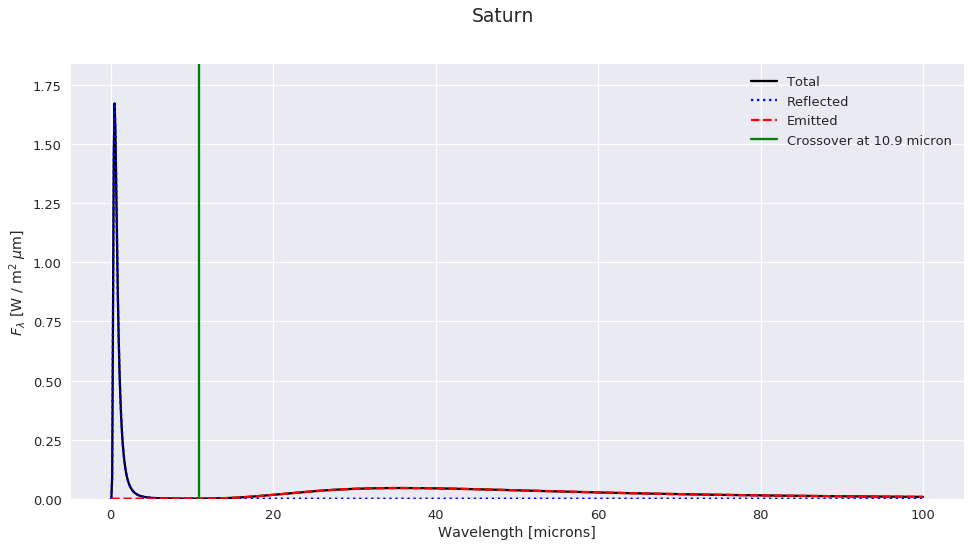

In [68]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[5], solar_planet_rad[5],
                                               constants.R_sun, solar_teff, solar_planet_albedo[5], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[5], wave_array)

/home/girish/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


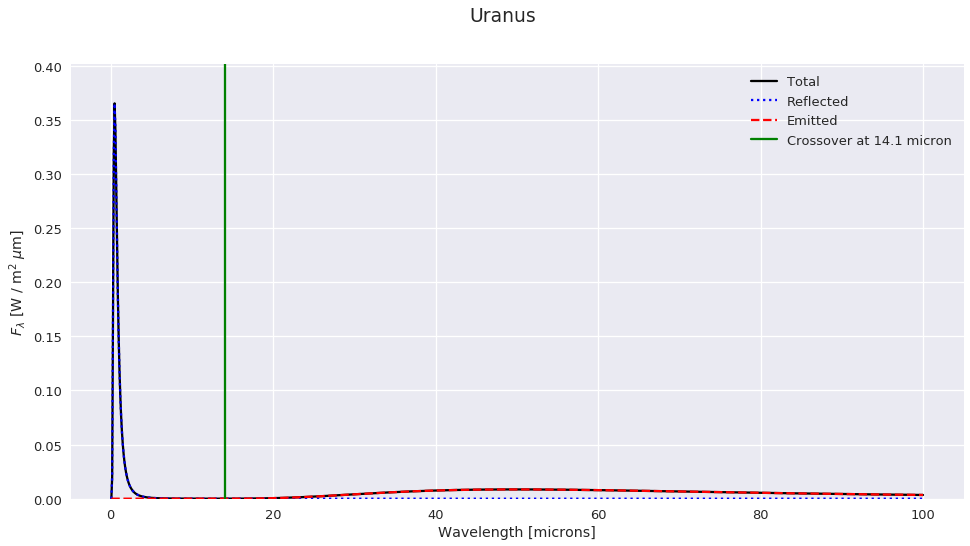

In [69]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[6], solar_planet_rad[6],
                                               constants.R_sun, solar_teff, solar_planet_albedo[6], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[6], wave_array)

/home/girish/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


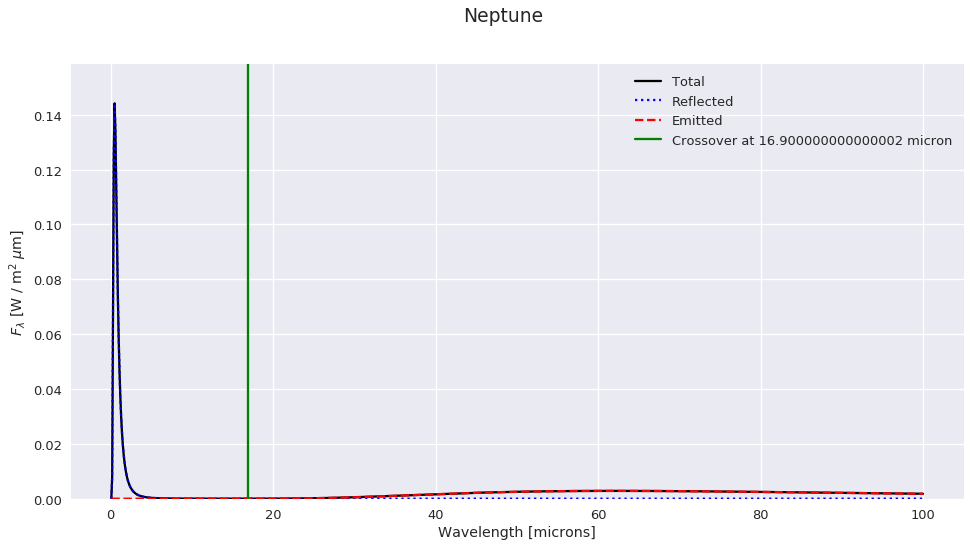

In [70]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[7], solar_planet_rad[7],
                                               constants.R_sun, solar_teff, solar_planet_albedo[7], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[7], wave_array)

/home/girish/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


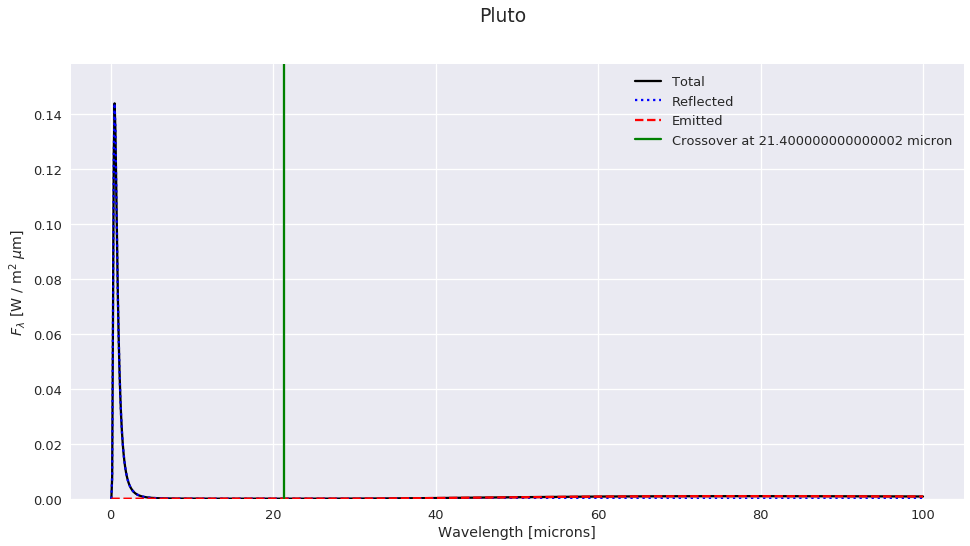

In [71]:
crossover, total, emit, reflect = get_spectrum(solar_planet_axis[8], solar_planet_rad[8],
                                               constants.R_sun, solar_teff, solar_planet_albedo[8], wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[8], wave_array)

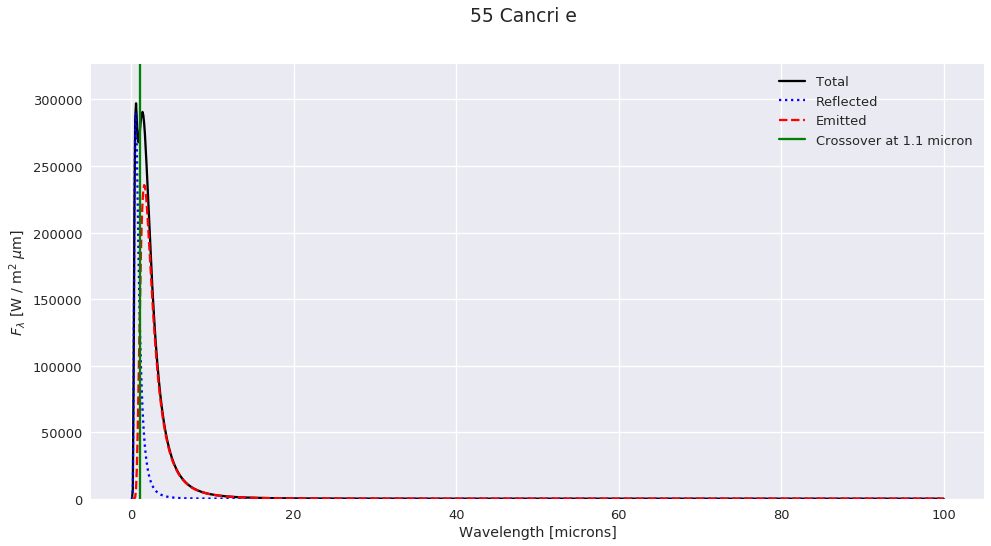

In [72]:
crossover, total, emit, reflect = get_spectrum(exo_axis[0], exo_planet_rad[0], exo_stell_rad[0],
                                               exo_teff[0], 0.3, wave_array)
plot_spectrum(crossover, total, emit, reflect, titles[-1], wave_array)

<font color='seagreen'>

### Q5: Glowing Humans

+ Compute the total power (in $W$) radiated by a person with a normal body temperature of $37^\circ C$. For the purposes of this problem, you can approximate a human is a $1.5m \times 0.5m \times 0.25m$ rectangular prism.
+ Approximately how many photons/second does this human emit with wavelengths in the range $5-10 \mu m$ (the mid-infrared)? What about $0.5-1 \mu m$ (the visible/near-infrared)? 
+ Compute the total power (in W) input that a human would consume, if they on average ate $2000$ kilocalories per day.
+ Why is it OK that that humans radiate so much more power than they ingest through food? 

In [73]:
human_temp = (37.0 + 273.15)*units.K
sa_human = (4.0*(1.5*0.5) + 2.0*(0.5*0.25))*(units.m**2.0)
human_lum = sa_human*constants.sigma_sb*(human_temp**4.0)
print_str_1 = 'The power radiated by a human is about ' + str(human_lum)
print(print_str_1,'\n')

wave_human_1 = np.linspace(5.0, 10.0, 1000)*units.micron
wave_human_2 = np.linspace(0.5, 1.0, 1000)*units.micron

energy_wave_1 = constants.h*constants.c/wave_human_1
energy_wave_2 = constants.h*constants.c/wave_human_2

human_spectrum_1 = sa_human*planck_flux(wave_human_1, human_temp)
human_spectrum_2 = sa_human*planck_flux(wave_human_2, human_temp)

photon_y_1 = human_spectrum_1/energy_wave_1
photon_y_2 = human_spectrum_2/energy_wave_2

photons_1 = np.trapz(photon_y_1, wave_human_1)
photons_2 = np.trapz(photon_y_2, wave_human_2)

print_str_2 = 'The number of photons per second emitted by a human in the 5 - 10 micron range is: ' + "{:E}".format(photons_1.value)
print_str_3 = 'The number of photons per second emitted by a human in the 0.5 - 1 micron range is: ' + "{:E}".format(photons_2.value)
print(print_str_2,'\n')
print(print_str_3,'\n')

units.imperial.enable()
power_consumed = (2000.0*units.imperial.kcal/units.day).to(units.W)
print_str_4 = 'The power consumed by a human is roughly ' + str(power_consumed)
print(print_str_4,'\n')
print_str_5 = 'The power emitted is largely re-radiated from power absorbed by incident light, not from food consumed.'
print(print_str_5)

The power radiated by a human is about 1705.224922449354 W 

The number of photons per second emitted by a human in the 5 - 10 micron range is: 1.890967E+28 

The number of photons per second emitted by a human in the 0.5 - 1 micron range is: 9.826419E+11 

The power consumed by a human is roughly 96.85185185185185 W 

The power emitted is largely re-radiated from power absorbed by incident light, not from food consumed.
